# Задача проекта - прогнозирование оттока клиентов Телеком

Оператор связи хочет научиться прогнозировать отток клиентов. Если выяснится, что пользователь планирует уйти, ему будут предложены промокоды и специальные условия. Команда оператора собрала персональные данные о некоторых клиентах, информацию об их тарифах и договорах.

## Описание услуг

Оператор предоставляет два основных типа услуг:

1.	Стационарную телефонную связь. Возможно подключение телефонного аппарата к нескольким линиям одновременно.

2.	Интернет. Подключение может быть двух типов: через телефонную линию (DSL*,* от англ. *digital subscriber line*, «цифровая абонентская линия») или оптоволоконный кабель (*Fiber optic*).

Также доступны такие услуги:
* Интернет-безопасность: антивирус (*DeviceProtection*) и блокировка небезопасных сайтов (*OnlineSecurity*);
* Выделенная линия технической поддержки (*TechSupport*);
* Облачное хранилище файлов для резервного копирования данных (*OnlineBackup*);
* Стриминговое телевидение (*StreamingTV*) и каталог фильмов (*StreamingMovies*).

За услуги клиенты могут платить каждый месяц или заключить договор на 1–2 года. Доступны различные способы расчёта и возможность получения электронного чека.


## Описание данных

Данные состоят из файлов, полученных из разных источников:
*	contract.csv — информация о договоре;
*	personal.csv — персональные данные клиента;
*	internet.csv — информация об интернет-услугах;
*	phone.csv — информация об услугах телефонии.

Во всех файлах столбец `customerID` содержит код клиента.

Информация о договорах актуальна на 1 февраля 2020.


### Обозначения признаков

* `BeginDate` – дата начала пользования услугами, 
* `EndDate` – дата окончания пользования услугами, 
* `Type` – тип оплаты: ежемесячный, годовой и тд, 
* `PaperlessBilling` – безналичный расчет, 
* `PaymentMethod` – способ оплаты, 
* `MonthlyCharges` – ежемесячные траты на услуги, 
* `TotalCharges` – всего потрачено денег на услуги 
* `Dependents` – наличие иждивенцев
* `Senior Citizen` – наличие пенсионного статуса по возрасту
* `Partner` – наличие супруга(и)
* `MultipleLines` – наличие возможности ведения параллельных линий во время звонка

## Критерии оценки работы

Основная метрика: `AUC-ROC > 0.8`. 

Дополнительная метрика: `Accuracy > 0.75`.


## Этап 1. Подготовка и предварительный анализ данных

Установим библиотеку `phik`, позволяющую изучать корреляционные связи смешанного набора данных (количественные и качественные переменные)

In [1]:
pip install phik

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


Установим библиотеку `catboost` для обучения модели категориального бустинга `CatBoostClassifier`.

In [2]:
pip install catboost

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
# Загрузим необходимые библиотеки и инструменты
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import phik
from phik.report import plot_correlation_matrix
from phik import report

from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, StratifiedShuffleSplit
from sklearn.preprocessing import StandardScaler, OrdinalEncoder, OneHotEncoder

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.dummy import DummyClassifier

from sklearn import metrics
from sklearn.metrics import make_scorer
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, roc_auc_score, roc_curve, plot_roc_curve, precision_recall_curve
from sklearn.metrics import classification_report, confusion_matrix

import warnings
warnings.filterwarnings('ignore')


Обычно данные хранятся в файле, которую нужно привести к виду таблицы.
Чаще всего вы будете работать с файлами .csv (англ. Comma-Separated Values, «значения, разделённые запятой»). Часто такие файлы с данными называют датасетами. 

Для чтения файла используют метод `read_csv()`. В качестве аргумента он принимает путь к файлу. Путь к файлу — строка с именем файла и каталогами, в которые он вложен. 

Например, прочитаем файл `file_name.csv` и перенесем данные из файла в датафрейм с именем `df`: 

`df = pd.read_csv('/file_name.csv')`.

In [4]:
# Прочитаем файлы с данными и изучим их
from google.colab import drive
drive.mount('/content/drive')
contract_df = pd.read_csv('/content/drive/My Drive/Churn/contract.csv')
internet_df = pd.read_csv('/content/drive/My Drive/Churn/internet.csv')
personal_df = pd.read_csv('/content/drive/My Drive/Churn/personal.csv')
phone_df = pd.read_csv('/content/drive/My Drive/Churn/phone.csv')
    

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Для того, чтобы выводить не весь DataFrame, а только часть, можно использовать следующие приемы:

* Вывод первых 5 строк - `df.head()`
* Вывод последних 5 строк - `df.tail()`
* Вывод 5 случайных строк - `df.sample(5)`

Полезные методы, которые вы можете использовать, для того, чтобы посмотреть на размер данных, названия признаков и их типы:

* `df.shape` - покаывает размер датафрейма

* `df.columns` - показывает названия признаков (столбцов)

* `df.dtypes` - показывает информацию о типах данных

* `df.info()` - показывает информацию о наборе данных, индекс, столбцы и тип данных, ненулевые значения и использование памяти.

* `df.describe()` - показывает количество строк в столбце, среднее значение столбца, столбец стандартное отклонение , минимальные (min) и максимальные (max) значения, а также границу каждого квартиля - 25%, 50% и 75%. Любые значения `NaN` автоматически пропускаются. По умолчанию, метод `describe( )` пропускает строки и столбцы не содержащие чисел - категориальные признаки. Чтобы посмотреть статистику по нечисловым признакам, нужно явно указать интересующие нас типы в параметре `include`. Можно также задать `include = 'all'`, чтоб вывести статистику по всем имеющимся признакам.


Для обнаружения недостающих данных используют методы isnull() и notnull().

Результатом является логическое значение, указывающее, действительно ли значение, переданное в аргумент, отсутствует. «Истина» означает, что значение является отсутствующим значением, а «Ложь» означает, что значение не является отсутствующим.

Сумма значений находится методом sum().

Например, `df.isnull().sum()` сформирует сводную таблицу с названием столбца таблицы и количеством пропущенных записей в этом столбце.

Для обнаружения явных дубликатов используют метод `duplicated()`.


Результатом является логическое значение, указывающее, действительно ли значение, переданное в аргумент, отсутствует. «Истина» означает, что значение является отсутствующим значением, а «Ложь» означает, что значение не является отсутствующим.

Сумма значений находится методом `sum()`.

Например, `df.duplicated().sum()` определит общее количество дублирующих записей во всем датасете.

In [5]:
# Для просмотра информации в файлах используем функцию present
def present(data):
    display(data.head())
    display(data.info())
    print('Количество пропусков')
    display(data.isnull().sum())
    print('Количество дубликатов')
    display(data.duplicated().sum())

### Информация о контрактах

Изучим каждый датасет отдельно.

Сначала изучим общую информацию о данных и устраним проблемы в данных, если они будут обнаружены (пропуски, дубликаты, несоответствие типов данных).

In [6]:
present(contract_df)

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,29.85
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,1889.5
2,3668-QPYBK,2019-10-01,2019-12-01 00:00:00,Month-to-month,Yes,Mailed check,53.85,108.15
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1840.75
4,9237-HQITU,2019-09-01,2019-11-01 00:00:00,Month-to-month,Yes,Electronic check,70.70,151.65


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   BeginDate         7043 non-null   object 
 2   EndDate           7043 non-null   object 
 3   Type              7043 non-null   object 
 4   PaperlessBilling  7043 non-null   object 
 5   PaymentMethod     7043 non-null   object 
 6   MonthlyCharges    7043 non-null   float64
 7   TotalCharges      7043 non-null   object 
dtypes: float64(1), object(7)
memory usage: 440.3+ KB


None

Количество пропусков


customerID          0
BeginDate           0
EndDate             0
Type                0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
dtype: int64

Количество дубликатов


0

В датасете с информацией о договоре пропущенных значений и дубликатов нет. Столбцы BeginDate и EndDate необходимо привести к типу `datetime`, столбец `TotalCharges` приведем к типу `float`.

В `Python` для данных, характеризующих дату какого-либо события, существует специальная структура `datetime`. Для изменения типа данных можно использовать метод `astype()`, который в качестве аргумента принимает тот формат данных, который необходимо получить.

In [7]:
contract_df['BeginDate'] = contract_df['BeginDate'].astype('datetime64')

Определим все уникальные записи в столбце `BeginDate`. Для этого используют метод `unique()`.

Метод `sort_values()` выполняет сортировку данных в порядке возрастания. Если необходимо изменить порядок сортировки, то в качестве аргумента метода `sort_values()` следует указать `scending=False`.

In [8]:
contract_df['EndDate'].sort_values().unique()

array(['2019-10-01 00:00:00', '2019-11-01 00:00:00',
       '2019-12-01 00:00:00', '2020-01-01 00:00:00', 'No'], dtype=object)

Среди уникальных записей даты окончания пользования услугами только четыре даты: первое число последних четырех месяцев перед выгрузкой базы. Скорее всего, оценка оттока клиентов проводится ежемесячно на первое число. Т.к. на дату выгрузки данных (01.02.2020) информации об оттоке клиентов нет, то заменим дату в столбце 'EndDate' для клиентов, которые продолжают пользоваться услугами, на текущую дату выгрузки, т.е. 01 февраля 2020. 

In [9]:
contract_df['EndDate'] = contract_df['EndDate'].replace('No','2020-02-01')
contract_df['EndDate'] = contract_df['EndDate'].astype('datetime64') 

В столбце `TotalCharges` хранятся сведения об общей сумме потраченных клиентом денег. Эти сведения - количественные, но имеют не соответствующий тип. Должны быть числами, а представлены как переменные типа `object`, т.е. символьная запись. Для перевода в числовой формат этих данных используем метод `to_numeric` из библиотеки `pandas`. В качестве аргумента метод принимает название столбца, данные которого необходимо перевести в числовой формат. Параметр `errors='coerce'` для недопустимого синтаксического значения будет установлен как `NaN`.

In [10]:
contract_df['TotalCharges'] = pd.to_numeric(arg=contract_df['TotalCharges'], errors='coerce')

In [11]:
# Ещё раз изучим информацию о датасете и проверим внесенные исправления
present(contract_df)

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
0,7590-VHVEG,2020-01-01,2020-02-01,Month-to-month,Yes,Electronic check,29.85,29.85
1,5575-GNVDE,2017-04-01,2020-02-01,One year,No,Mailed check,56.95,1889.50
2,3668-QPYBK,2019-10-01,2019-12-01,Month-to-month,Yes,Mailed check,53.85,108.15
3,7795-CFOCW,2016-05-01,2020-02-01,One year,No,Bank transfer (automatic),42.30,1840.75
4,9237-HQITU,2019-09-01,2019-11-01,Month-to-month,Yes,Electronic check,70.70,151.65


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   customerID        7043 non-null   object        
 1   BeginDate         7043 non-null   datetime64[ns]
 2   EndDate           7043 non-null   datetime64[ns]
 3   Type              7043 non-null   object        
 4   PaperlessBilling  7043 non-null   object        
 5   PaymentMethod     7043 non-null   object        
 6   MonthlyCharges    7043 non-null   float64       
 7   TotalCharges      7032 non-null   float64       
dtypes: datetime64[ns](2), float64(2), object(4)
memory usage: 440.3+ KB


None

Количество пропусков


customerID           0
BeginDate            0
EndDate              0
Type                 0
PaperlessBilling     0
PaymentMethod        0
MonthlyCharges       0
TotalCharges        11
dtype: int64

Количество дубликатов


0

После преобразования данных в столбце `TotalCharges` к типу `float` видим, что имеется 11 пропущенных значений в этом столбце. По всей видимости это была пустая строка, т.к. пользователи ещё не успели потратить какую-либо сумму на услуги, т.е. это новые клиенты. 

Сформируем таблицу с именем df, в которую сохраним те записи исходного датасета, в которых в столбце `TotalCharges` пропущенное значение. Эти данные найдем методом `isnull()`.

In [12]:
df = contract_df[contract_df['TotalCharges'].isnull() == True]
df

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
488,4472-LVYGI,2020-02-01,2020-02-01,Two year,Yes,Bank transfer (automatic),52.55,NaN
753,3115-CZMZD,2020-02-01,2020-02-01,Two year,No,Mailed check,20.25,NaN
936,5709-LVOEQ,2020-02-01,2020-02-01,Two year,No,Mailed check,80.85,NaN
1082,4367-NUYAO,2020-02-01,2020-02-01,Two year,No,Mailed check,25.75,NaN
1340,1371-DWPAZ,2020-02-01,2020-02-01,Two year,No,Credit card (automatic),56.05,NaN
3331,7644-OMVMY,2020-02-01,2020-02-01,Two year,No,Mailed check,19.85,NaN
3826,3213-VVOLG,2020-02-01,2020-02-01,Two year,No,Mailed check,25.35,NaN
4380,2520-SGTTA,2020-02-01,2020-02-01,Two year,No,Mailed check,20.00,NaN
5218,2923-ARZLG,2020-02-01,2020-02-01,One year,Yes,Mailed check,19.70,NaN
6670,4075-WKNIU,2020-02-01,2020-02-01,Two year,No,Mailed check,73.35,NaN


Проверим дату подключения этих абонентов и дату окончания действия их договора. Выведем все уникальные записи столбцов `BeginDate` и `EndDate` методом `unique()`.

In [13]:
df['BeginDate'].unique()

array(['2020-02-01T00:00:00.000000000'], dtype='datetime64[ns]')

In [14]:
df['EndDate'].unique()

array(['2020-02-01T00:00:00.000000000'], dtype='datetime64[ns]')

Предположение о том, что это абоненты, которых только что подключили, подтвердилось. Эти 11 записей составляют незначительную часть от общего объема данных, и не существенны для прогнозирования оттока. 

Поэтому есть два варианта:
1. удалим их;
2. заполним значением 0 или величиной ежемесячного платежа. 

Из полученного среза по пропущенным записям видим, что все новые абоненты выбрали тип оплаты за один или два года, но на дату выгрузки имеется только один ежемесячный платеж. Поэтому заполним пропущенные значения в столбце `TotalCharges` значением `MonthlyCharges`.

Для заполнения пропусков используем метод `fillna()`, который в качестве аргумента принимает значение, которым необходимо заполнить пропущенное значение во всем столбце. Параметр `inplace=True` означает, что заполнение произойдет в этом же датасете.

In [15]:
contract_df['TotalCharges'].fillna(contract_df['MonthlyCharges'], inplace=True)

In [16]:
# Проверим, остались ли пропуски
contract_df.isnull().sum()

customerID          0
BeginDate           0
EndDate             0
Type                0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
dtype: int64

Посмотрим, какие уникальные значения имеют остальные категориальные признаки

In [17]:
contract_df['Type'].unique()

array(['Month-to-month', 'One year', 'Two year'], dtype=object)

In [18]:
contract_df['PaperlessBilling'].unique()

array(['Yes', 'No'], dtype=object)

Тип оплаты имеет три различные категории, безналичный расчет - две категории. Нетипичных значений не наблюдается.

In [19]:
present(contract_df)

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
0,7590-VHVEG,2020-01-01,2020-02-01,Month-to-month,Yes,Electronic check,29.85,29.85
1,5575-GNVDE,2017-04-01,2020-02-01,One year,No,Mailed check,56.95,1889.50
2,3668-QPYBK,2019-10-01,2019-12-01,Month-to-month,Yes,Mailed check,53.85,108.15
3,7795-CFOCW,2016-05-01,2020-02-01,One year,No,Bank transfer (automatic),42.30,1840.75
4,9237-HQITU,2019-09-01,2019-11-01,Month-to-month,Yes,Electronic check,70.70,151.65


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   customerID        7043 non-null   object        
 1   BeginDate         7043 non-null   datetime64[ns]
 2   EndDate           7043 non-null   datetime64[ns]
 3   Type              7043 non-null   object        
 4   PaperlessBilling  7043 non-null   object        
 5   PaymentMethod     7043 non-null   object        
 6   MonthlyCharges    7043 non-null   float64       
 7   TotalCharges      7043 non-null   float64       
dtypes: datetime64[ns](2), float64(2), object(4)
memory usage: 440.3+ KB


None

Количество пропусков


customerID          0
BeginDate           0
EndDate             0
Type                0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
dtype: int64

Количество дубликатов


0

Аналогично изучим все остальные датасеты.

Вызовем функцию `present`, проверим типы данных, наличие пропусков и дубликатов.

### Персональные данные клиента

In [20]:
present(personal_df)

,customerID,gender,SeniorCitizen,Partner,Dependents
0,7590-VHVEG,Female,0,Yes,No
1,5575-GNVDE,Male,0,No,No
2,3668-QPYBK,Male,0,No,No
3,7795-CFOCW,Male,0,No,No
4,9237-HQITU,Female,0,No,No


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     7043 non-null   object
 1   gender         7043 non-null   object
 2   SeniorCitizen  7043 non-null   int64 
 3   Partner        7043 non-null   object
 4   Dependents     7043 non-null   object
dtypes: int64(1), object(4)
memory usage: 275.2+ KB


None

Количество пропусков


customerID       0
gender           0
SeniorCitizen    0
Partner          0
Dependents       0
dtype: int64

Количество дубликатов


0

Проверим все уникальные значения в категориальных переменных, чтобы убедиться, что в них нет нетипичных данных.

In [21]:
personal_df['gender'].unique()

array(['Female', 'Male'], dtype=object)

In [22]:
personal_df['SeniorCitizen'].unique()

array([0, 1])

In [23]:
personal_df['Partner'].unique()

array(['Yes', 'No'], dtype=object)

In [24]:
personal_df['Dependents'].unique()

array(['No', 'Yes'], dtype=object)

Персональные данные клиентов представлены категориальными признаками. Пропусков и дубликатов нет. Нехарактерных значений для указанных категорий не обнаружено.

Все категориальные признаки можно представить фиктивными переменными.

### Информация об интернет-услугах

In [25]:
present(internet_df)

,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
0,7590-VHVEG,DSL,No,Yes,No,No,No,No
1,5575-GNVDE,DSL,Yes,No,Yes,No,No,No
2,3668-QPYBK,DSL,Yes,Yes,No,No,No,No
3,7795-CFOCW,DSL,Yes,No,Yes,Yes,No,No
4,9237-HQITU,Fiber optic,No,No,No,No,No,No


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5517 entries, 0 to 5516
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   customerID        5517 non-null   object
 1   InternetService   5517 non-null   object
 2   OnlineSecurity    5517 non-null   object
 3   OnlineBackup      5517 non-null   object
 4   DeviceProtection  5517 non-null   object
 5   TechSupport       5517 non-null   object
 6   StreamingTV       5517 non-null   object
 7   StreamingMovies   5517 non-null   object
dtypes: object(8)
memory usage: 344.9+ KB


None

Количество пропусков


customerID          0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
dtype: int64

Количество дубликатов


0

In [26]:
internet_df['InternetService'].sort_values().unique()

array(['DSL', 'Fiber optic'], dtype=object)

Все признаки категориальные, пропусков и дубликатов нет. По числу записей понимаем, что не все клиенты пользовались интернет-услугами.

###  Информация об услугах телефонии

In [27]:
present(phone_df)

,customerID,MultipleLines
0,5575-GNVDE,No
1,3668-QPYBK,No
2,9237-HQITU,No
3,9305-CDSKC,Yes
4,1452-KIOVK,Yes


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6361 entries, 0 to 6360
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     6361 non-null   object
 1   MultipleLines  6361 non-null   object
dtypes: object(2)
memory usage: 99.5+ KB


None

Количество пропусков


customerID       0
MultipleLines    0
dtype: int64

Количество дубликатов


0

In [28]:
phone_df['MultipleLines'].unique()

array(['No', 'Yes'], dtype=object)

Единственный признак `MultipleLines` - наличие возможности ведения параллельных линий во время звонка - категориальный, пропусков и дубликатов нет. По числу записей понимаем, что не все клиенты пользовались услугами телефонии.

### Объединение таблиц

Объединим все таблицы по общему столбцу `customerID`. Для объединения используем метод `merge`. Последовательно будем присоединять по одной таблице к таблице `personal_df`.

In [29]:
df = pd.merge(personal_df, contract_df, how='outer', on=['customerID'])
df = pd.merge(df, internet_df, how='outer', on=['customerID'])
df = pd.merge(df, phone_df, how='outer', on=['customerID'])

In [30]:
# Проверим, что получилось после слияния таблиц с помощью функции present
present(df)

,customerID,gender,SeniorCitizen,Partner,Dependents,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,MultipleLines
0,7590-VHVEG,Female,0,Yes,No,2020-01-01,2020-02-01,Month-to-month,Yes,Electronic check,29.85,29.85,DSL,No,Yes,No,No,No,No,NaN
1,5575-GNVDE,Male,0,No,No,2017-04-01,2020-02-01,One year,No,Mailed check,56.95,1889.50,DSL,Yes,No,Yes,No,No,No,No
2,3668-QPYBK,Male,0,No,No,2019-10-01,2019-12-01,Month-to-month,Yes,Mailed check,53.85,108.15,DSL,Yes,Yes,No,No,No,No,No
3,7795-CFOCW,Male,0,No,No,2016-05-01,2020-02-01,One year,No,Bank transfer (automatic),42.30,1840.75,DSL,Yes,No,Yes,Yes,No,No,NaN
4,9237-HQITU,Female,0,No,No,2019-09-01,2019-11-01,Month-to-month,Yes,Electronic check,70.70,151.65,Fiber optic,No,No,No,No,No,No,No


<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   customerID        7043 non-null   object        
 1   gender            7043 non-null   object        
 2   SeniorCitizen     7043 non-null   int64         
 3   Partner           7043 non-null   object        
 4   Dependents        7043 non-null   object        
 5   BeginDate         7043 non-null   datetime64[ns]
 6   EndDate           7043 non-null   datetime64[ns]
 7   Type              7043 non-null   object        
 8   PaperlessBilling  7043 non-null   object        
 9   PaymentMethod     7043 non-null   object        
 10  MonthlyCharges    7043 non-null   float64       
 11  TotalCharges      7043 non-null   float64       
 12  InternetService   5517 non-null   object        
 13  OnlineSecurity    5517 non-null   object        
 14  OnlineBackup      5517 n

None

Количество пропусков


customerID             0
gender                 0
SeniorCitizen          0
Partner                0
Dependents             0
BeginDate              0
EndDate                0
Type                   0
PaperlessBilling       0
PaymentMethod          0
MonthlyCharges         0
TotalCharges           0
InternetService     1526
OnlineSecurity      1526
OnlineBackup        1526
DeviceProtection    1526
TechSupport         1526
StreamingTV         1526
StreamingMovies     1526
MultipleLines        682
dtype: int64

Количество дубликатов


0

In [31]:
# Определим количество уникальных пользователей методом nunique()
df['customerID'].nunique()

7043

Заполним пропущенные значения в столбцах `OnlineSecurity`, `OnlineBackup`, `DeviceProtection`, `TechSupport`, `StreamingTV`, `StreamingMovies` значением `No`, т.к. эти клиенты, скорее всего, не пользуются соответствующими услугами.

В столбце `InternetService` и `MultipleLines` заполним пропуски значением `unused`, т.к. скорее всего, эти абоненты не пользовались высокоскоростным интернетом.

In [32]:
df[['InternetService', 'MultipleLines']] = df[['InternetService', 'MultipleLines']].fillna('unused')
df = df.fillna('No')

In [33]:
df.isnull().sum()

customerID          0
gender              0
SeniorCitizen       0
Partner             0
Dependents          0
BeginDate           0
EndDate             0
Type                0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
MultipleLines       0
dtype: int64

Все пропущенные значения восстановлены.

### Выделение целевого признака

Для выделения целевого признака - факта оттока клиента, используем данные столбцов `BeginDate` и `EndDate`.

Определим в качестве текущей даты (переменная `actual_date`) дату выгрузки всех данных, т.е. 1 февраля 2020 года. 

Если для клиента в столбце `EndDate` сведения отсутствуют, то он ещё продолжает пользоваться услугами Телеком и не является "отточным" клиентом. Для таких клиентов установим класс 0. Если сведения в столбце `EndDate` есть, т.е. договор прекращен на дату `EndDate`, то этот клиент "отточный". Для него установим класс 1. 

In [34]:
actual_date = pd.to_datetime('2020-02-01', format='%Y-%m-%d')
df['churn'] = df['EndDate'].apply(lambda x: 1 if x!= actual_date else 0)
df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,...,TotalCharges,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,MultipleLines,churn
0,7590-VHVEG,Female,0,Yes,No,2020-01-01,2020-02-01,Month-to-month,Yes,Electronic check,...,29.85,DSL,No,Yes,No,No,No,No,unused,0
1,5575-GNVDE,Male,0,No,No,2017-04-01,2020-02-01,One year,No,Mailed check,...,1889.50,DSL,Yes,No,Yes,No,No,No,No,0
2,3668-QPYBK,Male,0,No,No,2019-10-01,2019-12-01,Month-to-month,Yes,Mailed check,...,108.15,DSL,Yes,Yes,No,No,No,No,No,1
3,7795-CFOCW,Male,0,No,No,2016-05-01,2020-02-01,One year,No,Bank transfer (automatic),...,1840.75,DSL,Yes,No,Yes,Yes,No,No,unused,0
4,9237-HQITU,Female,0,No,No,2019-09-01,2019-11-01,Month-to-month,Yes,Electronic check,...,151.65,Fiber optic,No,No,No,No,No,No,No,1


### Формирование нового признака

В качестве дополнительного признака, который может быть информативен и существенно влиять на вероятность оттока клиентов, сформируем продолжительность активности клиента. Период активности клиентов будем учитывать в днях. 

Сформируем столбец `activity_period`, равный количеству дней активности пользователей до дня их ухода. Для клиентов, которые продолжают пользоваться услугами, это значение будет равно числу дней с момента подключения до даты выгрузки из базы.

In [35]:
df['begin'] = ((actual_date - df['BeginDate'])// np.timedelta64(1, 'D')).astype(int)
df['end'] = ((actual_date - df['EndDate'])// np.timedelta64(1, 'D')).astype(int)
df['activity_period'] = (df['begin'] - df['end']).fillna(0).astype(int)
df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,...,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,MultipleLines,churn,begin,end,activity_period
0,7590-VHVEG,Female,0,Yes,No,2020-01-01,2020-02-01,Month-to-month,Yes,Electronic check,...,Yes,No,No,No,No,unused,0,31,0,31
1,5575-GNVDE,Male,0,No,No,2017-04-01,2020-02-01,One year,No,Mailed check,...,No,Yes,No,No,No,No,0,1036,0,1036
2,3668-QPYBK,Male,0,No,No,2019-10-01,2019-12-01,Month-to-month,Yes,Mailed check,...,Yes,No,No,No,No,No,1,123,62,61
3,7795-CFOCW,Male,0,No,No,2016-05-01,2020-02-01,One year,No,Bank transfer (automatic),...,No,Yes,Yes,No,No,unused,0,1371,0,1371
4,9237-HQITU,Female,0,No,No,2019-09-01,2019-11-01,Month-to-month,Yes,Electronic check,...,No,No,No,No,No,No,1,153,92,61


Удалим из датасета вспомогательный столбец `end`, а также даты начала и окончания пользования услугами, т.к. они теперь не являются информативными.

Удаление столбцов выполним методом `drop()`

In [36]:
df.drop(['end', 'BeginDate', 'EndDate'], axis = 1, inplace=True)
df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,...,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,MultipleLines,churn,begin,activity_period
0,7590-VHVEG,Female,0,Yes,No,Month-to-month,Yes,Electronic check,29.85,29.85,...,No,Yes,No,No,No,No,unused,0,31,31
1,5575-GNVDE,Male,0,No,No,One year,No,Mailed check,56.95,1889.50,...,Yes,No,Yes,No,No,No,No,0,1036,1036
2,3668-QPYBK,Male,0,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,...,Yes,Yes,No,No,No,No,No,1,123,61
3,7795-CFOCW,Male,0,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,...,Yes,No,Yes,Yes,No,No,unused,0,1371,1371
4,9237-HQITU,Female,0,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,...,No,No,No,No,No,No,No,1,153,61


## Этап 2. Исследовательский и статистический анализ данных

### Сбалансированность классов и оценка поведения клиентов разных групп

Определим количество записей каждого класса. Для этого используем метод `value_counts`, который выполняет группировку данных по указанному столбцу и подсчитывает количество записей каждого значения. если в качестве параметра указать `normalize=True`, то метод произведет вычисление значений с долевом отношении.

In [37]:
df['churn'].value_counts(normalize=True)

0    0.73463
1    0.26537
Name: churn, dtype: float64

Для визуального предствления числа записей каждого класса построим столбиковую диаграмму методом `countplot` из библиотеки `seaborn`.

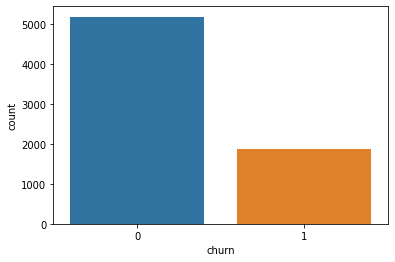

In [38]:
sns.countplot(df['churn'])
plt.show()

Датасет не является сбалансированным, количество объектов класса 0 значительно превышает (почти в 3 раза) количество объектов класса 1. Это как правило не приводит к высокой обощающей способности алгоритмов. Метрика `accuracy` будет некорректно отражать качество классификации. В таких случаях лучше использовать либо `f-меру`, либо меру Жаккарда. Для бинарной классификации оценку качества обощающей способности алгоритма также эффективно оценивать по метрике `ROC-AUC`. Метрика `ROC-AUC` не чувствительна к дисбалансу, но другие метрики чувствительны

Для устранения дисбаланса при инициации моделей будем использовать метод взвешивания классов, т.е. параметр `class_weight='balanced'`.

Изучим распределения признаков с помощью диаграмм рассеяния.

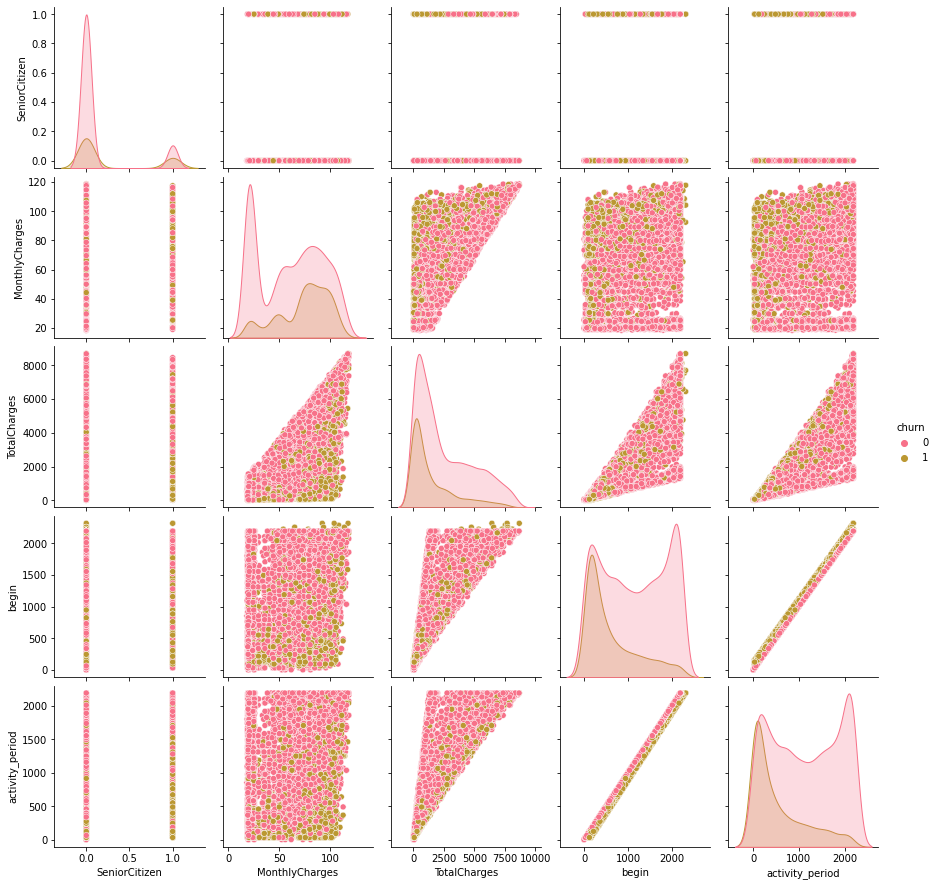

In [39]:
sns.set_palette('husl')
sns.pairplot(df,hue='churn', diag_kind='kde')
plt.show()

Видим, что ежемесячные траты и общая сумма потраченных денег на услуги для тех клиентов, которые остались, отличается, поэтому изучим эти признаки отдельно.

Построим диаграммы размаха ежемесячных и общих трат на услуги каждого типа клиентов.

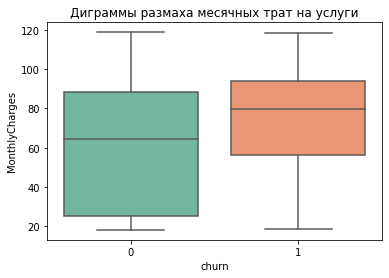

In [40]:
sns.set_palette('Set2')
sns.boxplot(x = df['churn'], y = df['MonthlyCharges'])
plt.title('Диграммы размаха месячных трат на услуги')
plt.show()

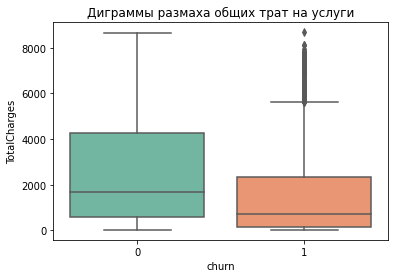

In [41]:
sns.boxplot(x = df['churn'], y = df['TotalCharges'])
plt.title('Диграммы размаха общих трат на услуги')
plt.show()

Оценим статистические характеристики каждого класса клиентов.

Для этого сформируем таблицы по клиентам каждого класса. Сформируем срез данных по условию наличия признака оттока, т.е. по значению в столбце `churn`.

Срез данных выполним методом `query()`, где в скобках необходимо указать условие, по которому данные будут отобраны.

In [42]:
df0 = df.query('churn == 0')
df1 = df.query('churn == 1')

Построим гистограммы распределения ежемесячных платежей "отточных" и "неотточных" клиентов. Гистограмма распределения строится методом `histplot`.

Т.к. число клиентов каждого класса не одинаково, то на одном графике эти сведения будут сильно различаться, поэтому построим гистограммы плотности распределения вероятностей ежемесячных платежей, чтобы площать под графиком была равна единице. Для этого в качестве параметра метода `histplot` необходимо указать `stat = 'density'`.

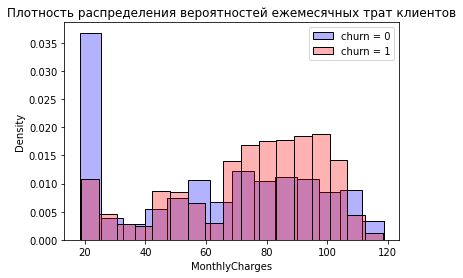

In [43]:
sns.histplot(df0['MonthlyCharges'],  stat = 'density', color = 'b', alpha = 0.3, label ='churn = 0')
sns.histplot(df1['MonthlyCharges'],   stat = 'density', color = 'r', alpha = 0.3, label ='churn = 1')
plt.legend(loc = 'best')
plt.title('Плотность распределения вероятностей ежемесячных трат клиентов')
plt.show()

Видно, что ежемесячные платежи заметно отличаются в двух группах.

"Неотточные" клиенты в своём большинстве платят небольшую сумму (пик около 20). Ежемесячные платежи "отточных" клиентов в большей степени располагаются в области от 70 до 110 ден. ед., что существенно выше. 


Построим гистограммы распределения вероятностей общих платежей "отточных" и "неотточных" клиентов. Гистограмма распределения строится методом `histplot` с параметром `stat = 'density'`.

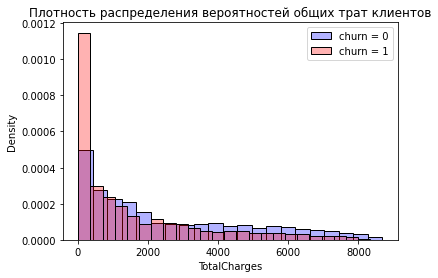

In [44]:
sns.histplot(df0['TotalCharges'],  stat = 'density', color = 'b', alpha = 0.3, label ='churn = 0')
sns.histplot(df1['TotalCharges'],   stat = 'density', color = 'r', alpha = 0.3, label ='churn = 1')
plt.legend(loc = 'best')
plt.title('Плотность распределения вероятностей общих трат клиентов')
plt.show()

Вычислим основные числовые характеристики параметров клиентов разный классов, чтобы лучше понимать причину ухода клиентов.

Для определения числовых характеристик используем метод  `describe()`.

In [45]:
df0.describe()

,SeniorCitizen,MonthlyCharges,TotalCharges,churn,begin,activity_period
count,5174.000000,5174.000000,5174.000000,5174.0,5174.000000,5174.000000
mean,0.128721,61.265124,2549.999497,0.0,1144.447236,1144.447236
std,0.334923,31.092648,2329.858843,0.0,733.897937,733.897937
min,0.000000,18.250000,18.800000,0.0,0.000000,0.000000
25%,0.000000,25.100000,572.900000,0.0,457.000000,457.000000
50%,0.000000,64.425000,1679.525000,0.0,1157.000000,1157.000000
75%,0.000000,88.400000,4262.850000,0.0,1857.000000,1857.000000
max,1.000000,118.750000,8672.450000,0.0,2191.000000,2191.000000


In [46]:
df1.describe()

,SeniorCitizen,MonthlyCharges,TotalCharges,churn,begin,activity_period
count,1869.000000,1869.000000,1869.000000,1869.0,1869.000000,1869.000000
mean,0.254682,74.441332,1531.796094,1.0,624.455324,547.352060
std,0.435799,24.666053,1890.822994,0.0,595.910567,594.389607
min,0.000000,18.850000,18.850000,1.0,62.000000,30.000000
25%,0.000000,56.150000,134.500000,1.0,153.000000,61.000000
50%,0.000000,79.650000,703.550000,1.0,365.000000,304.000000
75%,1.000000,94.200000,2331.300000,1.0,945.000000,883.000000
max,1.000000,118.350000,8684.800000,1.0,2314.000000,2191.000000


Видим, что среднее и медианное значение ежемесячных трат на услуги у клиентов, которые ушли, выше. Хотя совокупные траты на услуги для клиентов, которые остались, существенно выше. Возможно, уход этих клиентов связан с большими месячными тратами на услуги, которые были подключены, но клиентами не ииспользовались. Возможно, ушедшие клиенты - это клиенты, которые были подключены относительно недавно, поэтому общие траты ниже, чем для оставшихся клиентов. Средний период активности ушедших клиентов составляет 547 дней, в то время как медиана периода активности - 304 дня, т.е. большинство ушедших клиентов являются клиентами данной телеком компании около одного года. При этом следует обратить внимание на очень большое ср.кв. отклонение периода активности, которое составляет для ушедших клиентов 594 дня. 25% ушедших клиентов ушли через 2 месяца пользования услугами. Есть среди ушедших клиентов и те, кто пользовался услугами телеком очень длительный период. 75%-ый квантиль составляет 883 дня, т.е. почти 3 года, а максимальный период активности ушедших клиентов - 6 лет. Тем не менее среди ушедших клиентов 25% составляют клиенты телекома, которые были лояльны более двух лет.



Для оценки периода активности не ушедших клиентов следует вернуться к дате их подключения.

Построим гистограммы распределения количества дней с момента подключения к услугам клиентов каждого типа и периода активности.

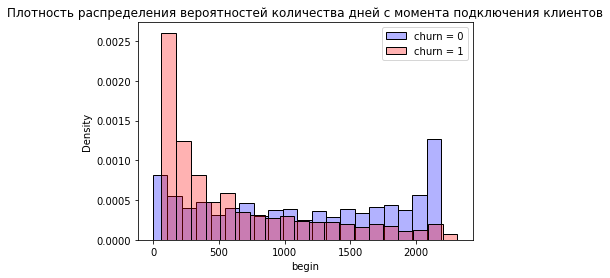

In [47]:
figsize=(16, 6)
sns.histplot(df0['begin'], bins = 20, color = 'b', stat = 'density', alpha = 0.3, label ='churn = 0')
sns.histplot(df1['begin'],  bins = 20, color = 'r', stat = 'density', alpha = 0.3, label ='churn = 1')
plt.title('Плотность распределения вероятностей количества дней с момента подключения клиентов')
plt.legend(loc = 'best')
plt.show()

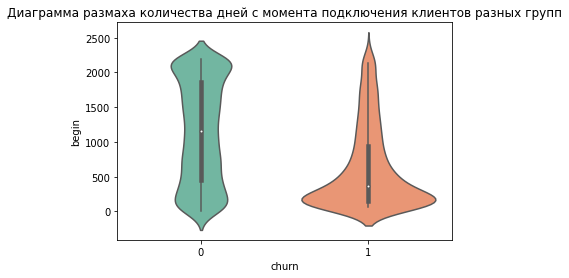

In [48]:
sns.violinplot(x=df['churn'], y=df['begin'])
plt.title('Диаграмма размаха количества дней с момента подключения клиентов разных групп')
plt.show()

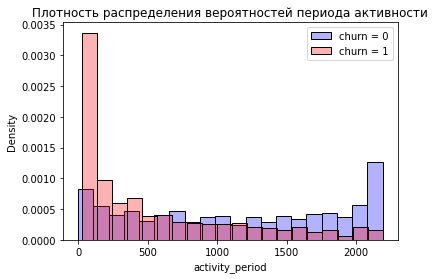

In [49]:
figsize=(16, 6)
sns.histplot(df0['activity_period'], bins = 20, color = 'b', stat = 'density', alpha = 0.3, label ='churn = 0')
sns.histplot(df1['activity_period'],  bins = 20, color = 'r', stat = 'density', alpha = 0.3, label ='churn = 1')
plt.title('Плотность распределения вероятностей периода активности')
plt.legend(loc = 'best')
plt.show()

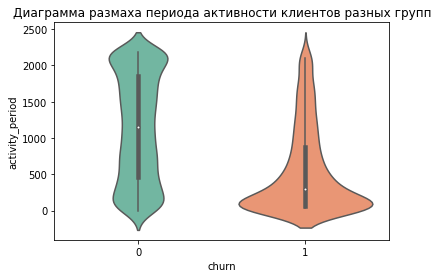

In [50]:
sns.violinplot(x=df['churn'], y=df['activity_period'])
plt.title('Диаграмма размаха периода активности клиентов разных групп')
plt.show()

Видим, что для ушедших клиентов характерен небольшой срок давности подключения. Среди оставшихся клиентов примерно одинаковое количество подключенных несколько дней назад и достаточно давно. При этом достаточно много клиентов, дата подключения которых более 2000 дней назад. Для ушедших клиентов распределение периода подключения похоже на экспоненциальное, т.е. для большого количества клиентов более характерны небольшие периоды, т.е. в большинстве это новые клиенты, подключенные около 1-1.5 лет назад.

Оценим, какими услугами преимущественно пользуются клиенты каждой группы, какие предпочитают способы оплаты, тарифы, какого они преимущественно пола и пенсионного статуса. 

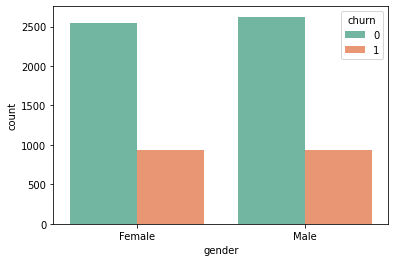

In [51]:
sns.countplot(x = df['gender'], hue = df['churn'])
plt.show()

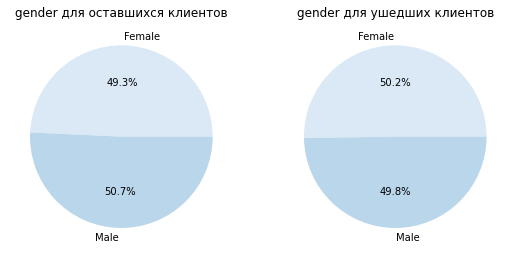

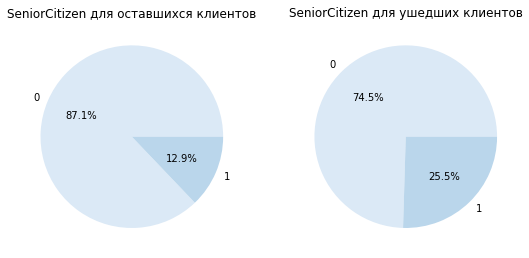

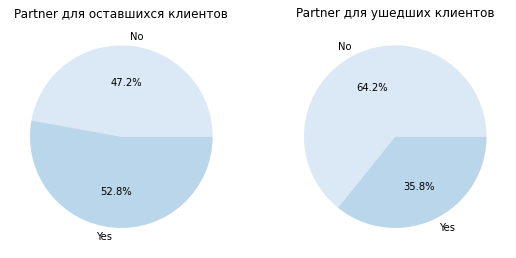

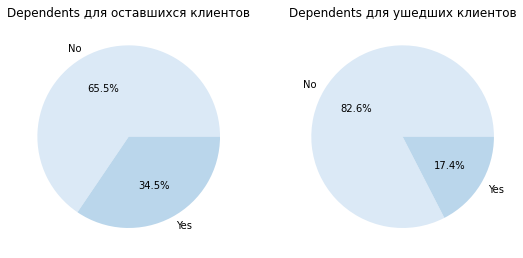

In [52]:
feature = ['gender', 'SeniorCitizen', 'Partner', 'Dependents']

for name in feature:
    f0 = df0.groupby(name)['churn'].count()
    f1 = df1.groupby(name)['churn'].count()
    
    sns.set_palette('Blues')
    fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(9, 6))
    ax1.set_title(name+ ' для оставшихся клиентов')
    ax1.pie(f0.values, labels=f0.index, autopct='%1.1f%%')  
    ax2.set_title(name+ ' для ушедших клиентов')
    ax2.pie(f1.values, labels=f1.index, autopct='%1.1f%%')  
    plt.show()
    

Видим, что доля мужчин и женщин как среди оставшихся, так и среди ушедших клиентов примерно одинаковая. Поэтому этот признак, скорее всего мало оказывает влияния на целевой фактор.

Как среди оставшихся, так и среди ушедших клиентов преобладают клиенты без статуса пенсионеров по возрасту. Среди ушедших доля клиентов пенсионеров почти в 2 раза превышает долю пенсионеров для оставшихся клиентов и составляет 25.5%

Для 64.2% клиентов, которые ушли, отсутствует супруг, в то время как для оставшихся клиентов только 47.2% супруга не имеют.


Для всех клиентов характерно отсутствие иждивенцев, но для ушедших клиентов их доля существенно выше, чем для оставшихся клиентов, и составляет 82.6% против 65.5%.

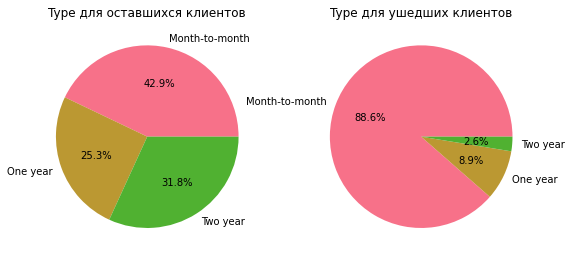

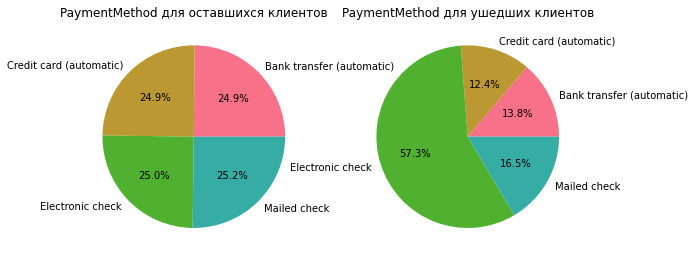

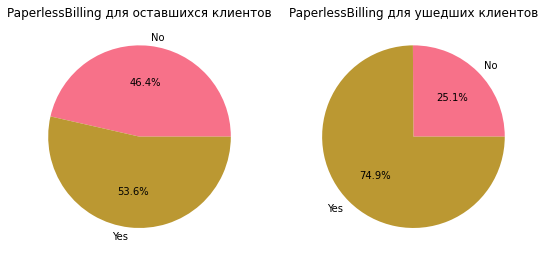

In [53]:
feature = ['Type', 'PaymentMethod', 'PaperlessBilling']

for name in feature:
    f0 = df0.groupby(name)['churn'].count()
    f1 = df1.groupby(name)['churn'].count()
    
    sns.set_palette('husl')
    fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(9, 6))
    ax1.set_title(name+ ' для оставшихся клиентов')
    ax1.pie(f0.values, labels=f0.index, autopct='%1.1f%%')  
    ax2.set_title(name+ ' для ушедших клиентов')
    ax2.pie(f1.values, labels=f1.index, autopct='%1.1f%%')  
    plt.show()

Для ушедших клиентов наиболее характерен помесячный тип оплаты. Доля таких клиентов составила почти 88.6%, для оставшихся клиентов такой способ оплаты выбирают 42.9%. Оплату за два года среди ушедших выбрали только 2.6%, в то время как среди оставшихся такой формат оплаты предпочли 31.8%. 

Для оставшихся клиентов все четыре способа оплаты одинаково предпочтительны, т.е. примерно одинаковое количество клиентов используют автоматические переводы с кредитных карт, автоматический банковский перевод, электронную оплату и оплату по почте. Для ушедших клиентов наиболее предпочтительным является электронная оплата, этот способ оплаты выбирает более 57% клиентов. Наименее популярным способом оплаты услуг для ушедших клиентов является автоматическая оплата кредитной картой.

Для всех клиентов более предпочтителен безналичный расчет. Однако для ушедших клиентов этот способ расчета выбирают около 75% клиентов, в то время как для оставшихся клиентов доля предпочитающих безналичный расчет составляет около 54%.

Оценим долю пользователей телефонной связи и интернета.

In [54]:
df.columns

Index(['customerID', 'gender', 'SeniorCitizen', 'Partner', 'Dependents',
       'Type', 'PaperlessBilling', 'PaymentMethod', 'MonthlyCharges',
       'TotalCharges', 'InternetService', 'OnlineSecurity', 'OnlineBackup',
       'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies',
       'MultipleLines', 'churn', 'begin', 'activity_period'],
      dtype='object')

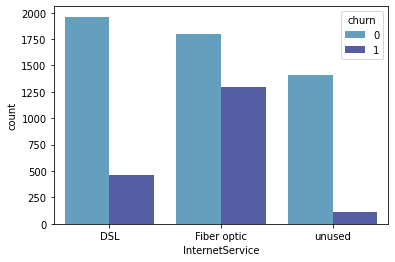

In [55]:
sns.set_palette('icefire')
sns.countplot(x = df['InternetService'], hue = df['churn'])
plt.show()

Среди ушедших клиентов большинство были подключены по оптоволокну. Почти в три раза меньше ушедших клиентов, которые использовали технологию DSL, а среди тех, кто ушел, доля не пользовавшихся интернетом незначительна.

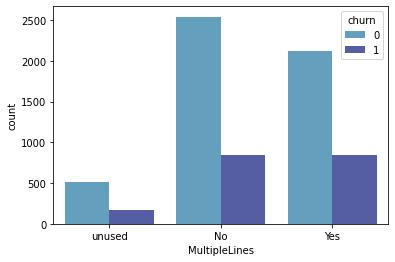

In [56]:
sns.set_palette('icefire')
sns.countplot(x = df['MultipleLines'], hue = df['churn'])
plt.show()

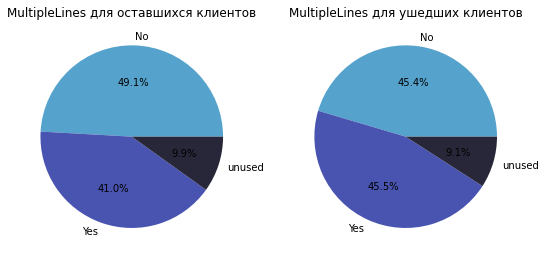

In [57]:
f0 = df0.groupby('MultipleLines')['churn'].count()
f1 = df1.groupby('MultipleLines')['churn'].count()
    
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(9, 6))
ax1.set_title('MultipleLines для оставшихся клиентов')
ax1.pie(f0.values, labels=f0.index, autopct='%1.1f%%')  
ax2.set_title('MultipleLines для ушедших клиентов')
ax2.pie(f1.values, labels=f1.index, autopct='%1.1f%%')  
plt.show()

Для ушедших клиентов примерно одинаковое количество тех, кто использовал возможности ведения параллельных линий во время звонка и не использовал. Для оставшихся клиентов доля использующих такую возможность составляет 41.0% против 45.5% для ушедших клиентов. Разница в пропорциях достаточно незначительная, поэтому, скорее всего, этот признак не является значимым для прогнозирования оттока клиентов. 

Таким образом, видим, что выделенные классы клиентов имеют существенные отличия по большинству изученных показателей. Т.е. все категориальные признаки могут быть полезными для задачи прогнозирования оттока клиентов. Изучим корреляционную зависимость между признаками и целевым фактором.

### Изучение корреляционных связей

Идентификатор пользователя нам больше не пригодится, поэтому эти сведения удалим из датасета. Также исключим вспомогательный столбец `begin`. 

In [58]:
df.drop(['customerID', 'begin'], axis = 1, inplace = True)

Построим матрицу парных коэффициентов корреляции методом `corr()`. Сохраним эти сведения в таблицу с именем `corr`.

In [59]:
corr = df[['MonthlyCharges', 'TotalCharges', 'activity_period', 'churn']].corr()
corr


,MonthlyCharges,TotalCharges,activity_period,churn
MonthlyCharges,1.000000,0.651182,0.247754,0.193356
TotalCharges,0.651182,1.000000,0.826095,-0.198347
activity_period,0.247754,0.826095,1.000000,-0.352673
churn,0.193356,-0.198347,-0.352673,1.000000


Для визуализации матрица парных коэффициентов корреляции используем тепловую карту. Её можно построить методом `heatmap`.

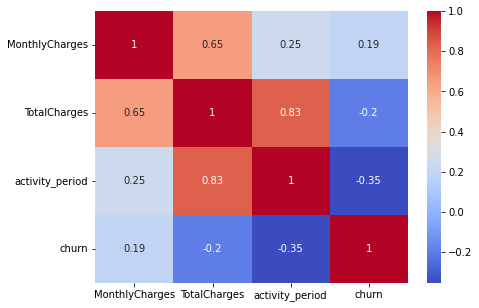

In [60]:
plt.figure(figsize=(7,5))
sns.heatmap(corr, cmap='coolwarm', annot = True, xticklabels = corr.columns, yticklabels = corr.columns)
plt.show()

Наиболее тесная линейная связь между оттоком клиентов и периодом активности с коэффициентом корреляции -0.35. При этом видим более тесную прямую линейную связь между общими тратами и ежемесячными тратами (коэффициент корреляции 0.65), а также между периодом активности и общими тратами (коэффициент корреляции 0.83), что вполне логично.

Используем возможности вспомогательной библиотеки `phik`, которая может работать на смешанном наборе данных (есть качественные и количественные переменные).

Построим матрицу парных коэффицентов корреляции по всему набору признаков методом `phik_matrix()`.  Метод `round(2)` округляет значения коэффициентов корреляции до двух знаков

In [61]:
phik_overview = df.phik_matrix().round(2)
phik_overview

interval columns not set, guessing: ['SeniorCitizen', 'MonthlyCharges', 'TotalCharges', 'churn', 'activity_period']


,gender,SeniorCitizen,Partner,Dependents,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,MultipleLines,churn,activity_period
gender,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.01,0.00,0.00,0.02,0.01,0.00,0.00,0.00,0.00,0.00,0.00,0.00
SeniorCitizen,0.00,1.00,0.02,0.32,0.09,0.24,0.29,0.30,0.15,0.16,0.06,0.10,0.09,0.09,0.16,0.19,0.09,0.23,0.03
Partner,0.00,0.02,1.00,0.65,0.18,0.01,0.24,0.20,0.42,0.00,0.22,0.22,0.24,0.19,0.19,0.18,0.09,0.23,0.49
Dependents,0.00,0.32,0.65,1.00,0.15,0.17,0.22,0.18,0.11,0.11,0.12,0.03,0.01,0.10,0.02,0.06,0.01,0.25,0.21
Type,0.00,0.09,0.18,0.15,1.00,0.11,0.28,0.39,0.51,0.51,0.15,0.10,0.14,0.18,0.07,0.07,0.24,0.25,0.66
PaperlessBilling,0.00,0.24,0.01,0.17,0.11,1.00,0.37,0.47,0.21,0.23,0.00,0.20,0.16,0.06,0.34,0.33,0.10,0.30,0.00
PaymentMethod,0.00,0.29,0.24,0.22,0.28,0.37,1.00,0.40,0.35,0.32,0.26,0.28,0.31,0.27,0.38,0.38,0.17,0.45,0.38
MonthlyCharges,0.01,0.30,0.20,0.18,0.39,0.47,0.40,1.00,0.76,0.92,0.55,0.63,0.67,0.58,0.84,0.83,0.71,0.36,0.41
TotalCharges,0.00,0.15,0.42,0.11,0.51,0.21,0.35,0.76,1.00,0.51,0.54,0.66,0.67,0.57,0.66,0.67,0.49,0.28,0.84
InternetService,0.00,0.16,0.00,0.11,0.51,0.23,0.32,0.92,0.51,1.00,0.24,0.23,0.23,0.24,0.27,0.27,0.74,0.20,0.02


Для визуализации построим тепловую карту полученной матрицы парных коэффицентов корреляции смешанного набора данных. При этом уточним, какие столбцы являются количественными (названия количественных столбцов указаны в переменной `interval_cols`)

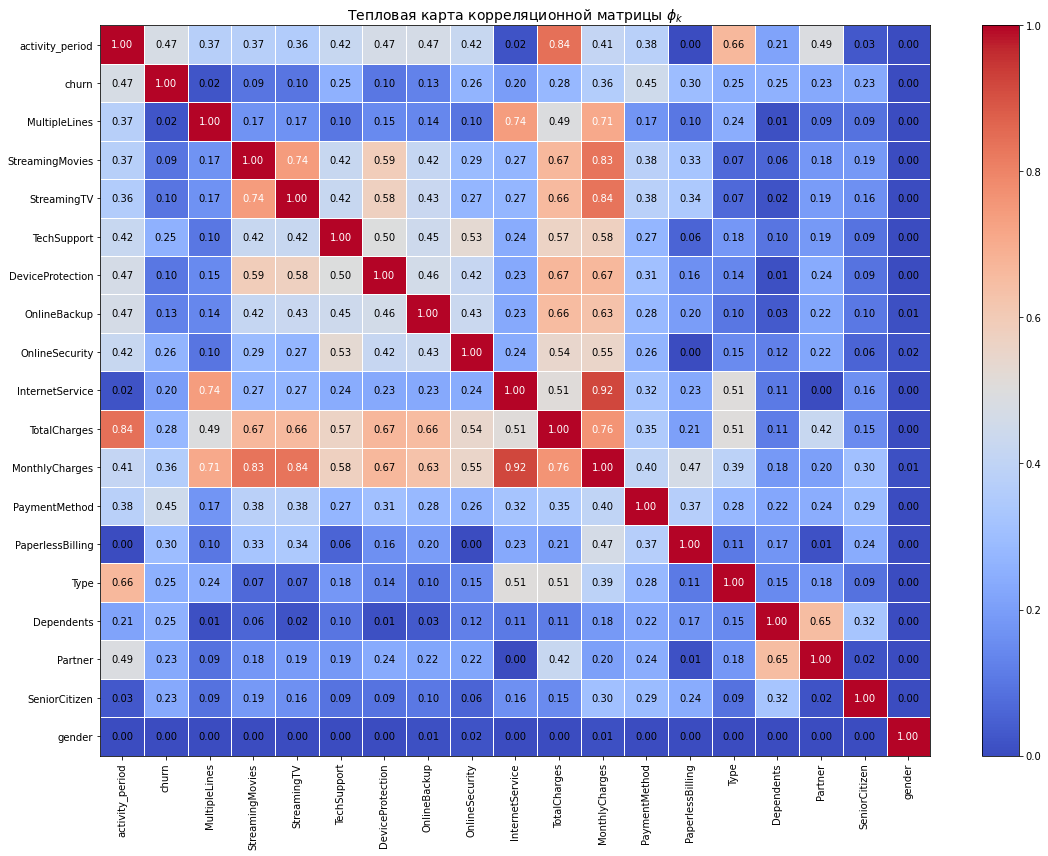

In [62]:
interval_cols = ['SeniorCitizen', 'MonthlyCharges', 'TotalCharges', 'churn', 'begin', 'activity_period']
phik_overview = df.phik_matrix(interval_cols=interval_cols)

plot_correlation_matrix(phik_overview.values, 
                        x_labels=phik_overview.columns, 
                        y_labels=phik_overview.index, 
                        vmin=0, vmax=1, color_map='coolwarm', 
                        title= 'Тепловая карта корреляционной матрицы $\phi_k$', 
                        figsize=(16, 12))
plt.tight_layout()

Видим наличие корреляции между оттоком клиентов и периодом активности.

Также достаточно высокие значения корреляции между значениями ежемесячных трат на услуги и признаками, характеризующими услуги, которые по всей видимости и были оплачены ежемесячно. Схожая картина с высокой корреляцией наблюдается и для общих трат на услуги и самими услугами.

Также высокая корреляция между общими тратами и количеством дней с момента подключения клиента.

Оценим статистическую значимость коэффициентов корреляции. Для этого используем метод `significance_matrix`. Для визуализации полученных статистик построим тепловую карту.

Запись `plt.tight_layout()` позволяет уплотнить график в указанный диапазон

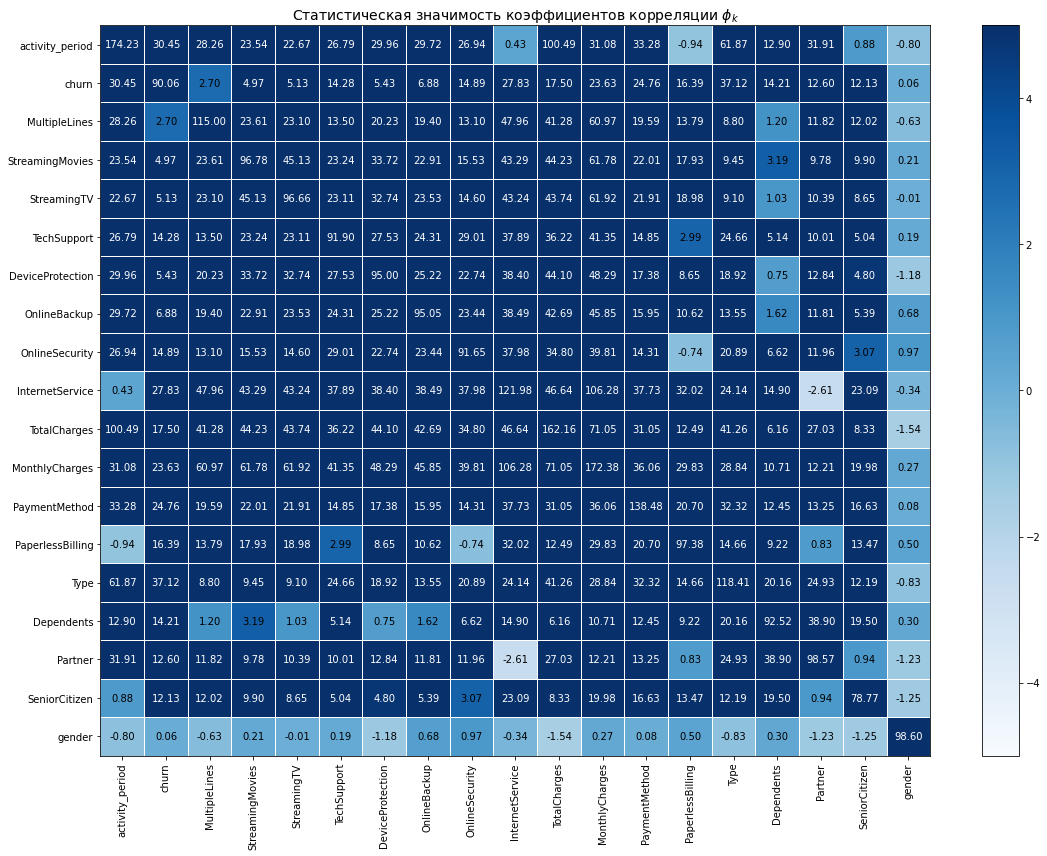

In [63]:
significance_overview = df.significance_matrix(interval_cols=interval_cols)
plot_correlation_matrix(significance_overview.values, 
                        x_labels=significance_overview.columns, 
                        y_labels=significance_overview.index, 
                        vmin=-5, vmax=5, title="Статистическая значимость коэффициентов корреляции $\phi_k$", 
                        color_map='Blues', usetex=False, figsize=(16, 12))
plt.tight_layout()

Наименее значимой можно считать корреляцию между признаком пола клиента и всеми остальными признаками. 

Оценим глобальный коэффициент корреляции

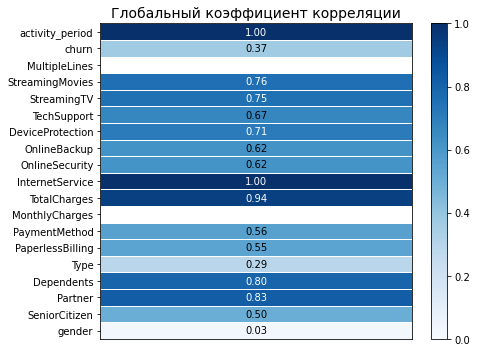

In [64]:
global_correlation, global_labels = df.global_phik(interval_cols=interval_cols)

plot_correlation_matrix(global_correlation, 
                        x_labels=[''], y_labels=global_labels, 
                        vmin=0, vmax=1,
                        color_map='Blues', title='Глобальный коэффициент корреляции')
plt.tight_layout()

Многие переменные имеют довольно высокие значения глобальной метрики корреляции, самое высокое значение которой составляет `activity_period`, `InternetService`, `TotalCharges`, `Partner` и `Dependents`. Т.е. целевой признак можно представить через остальные признаки достаточно полно.

Можно наименее информативные признаки удалить. Но обычно высокая корреляция категориальных признаков — это пища для размышлений, тем не менее можно обучить модель и с этими признаками, а затем исследовать важность признаков в модели (feature_importances). Анализ важности признаков - это мощный инструмент для отбора признаков, его можно рассмотреть в паре с корреляциями.
    
Стоит отметить, что у нас есть еще пара числовых признаков с высокой взаимной корреляцией. Некоторые модели, например линейная регрессия, чувствительны к мультиколлинеарности, поэтому этот момент нужно исключать, либо добавить регуляризаторы в модель.


Для исключения взаимного влияния прикнаков друг на друга и снижения их совокупного усиленного влияния на целевой признак, удалим `TotalCharges`. 

In [65]:
# Удалим неинформативные признаки.
df.drop(['TotalCharges'], axis = 1, inplace = True)
df.head()

,gender,SeniorCitizen,Partner,Dependents,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,MultipleLines,churn,activity_period
0,Female,0,Yes,No,Month-to-month,Yes,Electronic check,29.85,DSL,No,Yes,No,No,No,No,unused,0,31
1,Male,0,No,No,One year,No,Mailed check,56.95,DSL,Yes,No,Yes,No,No,No,No,0,1036
2,Male,0,No,No,Month-to-month,Yes,Mailed check,53.85,DSL,Yes,Yes,No,No,No,No,No,1,61
3,Male,0,No,No,One year,No,Bank transfer (automatic),42.30,DSL,Yes,No,Yes,Yes,No,No,unused,0,1371
4,Female,0,No,No,Month-to-month,Yes,Electronic check,70.70,Fiber optic,No,No,No,No,No,No,No,1,61


## Этап 3. Обучение и тестирование моделей ML

### Подготовка данных

In [66]:
# Создадим переменные для признаков features и целевого признака target
features = df.drop(['churn'], axis=1)
target = df['churn']

Разобьем выборку на обучающую и тестовую в отношении 0.75:0.25. Для этого используем `train_test_split`. Для воспроизводимости результатов укажем параметр `random_state`, а для сохранения пропорции классов в обучающем и тестовом наборах используем параметр `stratify = target`, т.е будут сохранены пропорции классов по данным массива `target`.

In [67]:
features_train, features_test, target_train, target_test = train_test_split(features,
                                                                            target,
                                                                            test_size=0.25,
                                                                            random_state=210223,
                                                                            stratify = target,
                                                                            shuffle=True)
print('Размерность обучающего набора',features_train.shape)
print('Размерность тестовой выборки',features_test.shape)

Размерность обучающего набора (5282, 17)
Размерность тестовой выборки (1761, 17)


Линейные и метрические модели достаточно чувствительны к выбросам, поэтому количественные признаки лучше стандартизировать. 

Для масштабирования и кодирования зафиксируем количественные признаки и категориальные

In [68]:
numeric = ['MonthlyCharges', 'activity_period'] 
categorical = ['gender', 'SeniorCitizen', 'Partner', 'Dependents', 'Type',
       'PaperlessBilling', 'PaymentMethod','InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection',
       'TechSupport', 'StreamingTV', 'StreamingMovies', 'MultipleLines']

In [69]:
for name in categorical:
    features_train[name] = features_train[name].astype('category')

In [70]:
# Порядковое кодирование категориальных признаков для деревянных моделей. Используем класс OrdinalEncoder() для категориальных признаков.
# Модели, построенные на основе решающих деревьев, не чувствительны к выбросам, поэтому стандартизацию количественных признаков делать не нужно
features_train_cat = features_train.copy()
ord_enc = OrdinalEncoder()
features_train_cat[categorical] = ord_enc.fit_transform(features_train_cat[categorical])
features_train_cat.head()


,gender,SeniorCitizen,Partner,Dependents,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,MultipleLines,activity_period
5621,0.0,0.0,1.0,0.0,0.0,1.0,1.0,74.75,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,91
1183,0.0,0.0,1.0,0.0,1.0,1.0,2.0,93.45,1.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,1614
4512,0.0,1.0,0.0,0.0,2.0,1.0,0.0,75.50,0.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0,2132
1328,0.0,0.0,1.0,0.0,0.0,0.0,2.0,54.25,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,702
5635,0.0,0.0,1.0,0.0,0.0,1.0,3.0,54.70,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,671


In [71]:
# Стандартизация количественных признаков. Инициируем класс StandardScaler() и нормализует количественные признаки
features_train_num = features_train[numeric]

scaler = StandardScaler()
scaler.fit(features_train_num)

features_train_num = pd.DataFrame(scaler.transform(features_train_num), columns = features_train_num.columns)

#features_test[numeric] = scaler.transform(features_test[numeric])


In [72]:
# Кодирование категориальных признаков методом OHE. Инициируем класс OneHotEncoder() и выполним кодирование категориальных признаков
ohe_enc = OneHotEncoder(drop = 'first')
ohe_enc.fit(features[categorical])
ohe_features = ohe_enc.get_feature_names(categorical)
features_train_ohe = pd.DataFrame(ohe_enc.transform(features_train[categorical]).toarray(), columns = ohe_features)


In [73]:
# Объединим преобразованные методом OHE категориальные признаки с количественными в один набор признаков features_train_ohe
features_train_ohe = features_train_ohe.join(features_train_num.reset_index())


In [74]:
# проверим названия столбцов после объединения данных
features_train_ohe.columns

Index(['gender_Male', 'SeniorCitizen_1', 'Partner_Yes', 'Dependents_Yes',
       'Type_One year', 'Type_Two year', 'PaperlessBilling_Yes',
       'PaymentMethod_Credit card (automatic)',
       'PaymentMethod_Electronic check', 'PaymentMethod_Mailed check',
       'InternetService_Fiber optic', 'InternetService_unused',
       'OnlineSecurity_Yes', 'OnlineBackup_Yes', 'DeviceProtection_Yes',
       'TechSupport_Yes', 'StreamingTV_Yes', 'StreamingMovies_Yes',
       'MultipleLines_Yes', 'MultipleLines_unused', 'index', 'MonthlyCharges',
       'activity_period'],
      dtype='object')

In [75]:
#Удалим столбец index, который образовался после объединения количественных и категориальных переменных методом drop
features_train_ohe.drop(['index'], axis=1, inplace = True)

In [76]:
features_train_ohe.head()

,gender_Male,SeniorCitizen_1,Partner_Yes,Dependents_Yes,Type_One year,Type_Two year,PaperlessBilling_Yes,PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check,...,OnlineSecurity_Yes,OnlineBackup_Yes,DeviceProtection_Yes,TechSupport_Yes,StreamingTV_Yes,StreamingMovies_Yes,MultipleLines_Yes,MultipleLines_unused,MonthlyCharges,activity_period
0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.337157,-1.192930
1,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,...,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.954748,0.844264
2,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,...,0.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0,0.361927,1.537151
3,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,-0.339880,-0.375645
4,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,...,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,-0.325019,-0.417111


Для обучения моделей будем использовать метод кросс-валидации, поэтому определим параметры этого метода. Данные будем перемешивать и для валидации использовать 10% имеющихся данных на каждой итерации.

In [77]:
cv = StratifiedShuffleSplit(n_splits=10, test_size = 0.1, random_state = 210223)



### Обучение и оценка адекватности моделей ML

#### KNN Classifier

Определим диапазон гиперпараметров модели 

In [78]:
param_grid = {'n_neighbors': [5, 7, 8, 9, 10, 11, 12, 13],
             'weights': ['uniform', 'distance']}

Кросс-валидацию будем проводить методом GridSearchCV. Т.к. ключевой метрикой является `roc-auc`, то обучение будем проводить при условии максимизации указанной метрики.



In [79]:
knn_model = GridSearchCV(KNeighborsClassifier(p=2), param_grid, cv = cv, scoring = 'roc_auc', n_jobs = -1)

In [80]:
# Обучение модели проводится методом fit
knn_model.fit(features_train_ohe, target_train)

GridSearchCV(cv=StratifiedShuffleSplit(n_splits=10, random_state=210223, test_size=0.1,
            train_size=None),
             estimator=KNeighborsClassifier(), n_jobs=-1,
             param_grid={'n_neighbors': [5, 7, 8, 9, 10, 11, 12, 13],
                         'weights': ['uniform', 'distance']},
             scoring='roc_auc')

In [81]:
print('Параметры лучшей модели', knn_model.best_params_)

Параметры лучшей модели {'n_neighbors': 13, 'weights': 'uniform'}


Результаты обучения всех моделей будем сохранять в таблицу `Results`, в которой укажем название метода, метрику `roc-auc` на валидационной выборке, а также вреся обучения данной модели на валидационном наборе.

In [82]:
Results = pd.DataFrame({'Model' : 'KNN',
                       'ROC-AUC score valid' : knn_model.best_score_,
                       'Fit time': knn_model.cv_results_["mean_fit_time"][knn_model.best_index_]
                        }, index=[0])

#### LogisticRegression

В качестве гиперпараметра модели будем выбирать коэффициент регуляризации `C`.

In [83]:
param_grid = {'C' : [0.01, 0.05, 0.1, 0.5, 1, 5, 10]}


In [84]:
lr_model = GridSearchCV(LogisticRegression(solver = 'lbfgs', class_weight='balanced', max_iter=1000), param_grid, cv = cv, n_jobs = -1, scoring = 'roc_auc')

Здесь решатель `lbfgs` поддерживает `L2` регуляризацию. Можно указать `solver = 'liblinear'`, который поддерживает `L1` и `L2` регуляризацию. 

In [85]:
lr_model.fit(features_train_ohe, target_train)

GridSearchCV(cv=StratifiedShuffleSplit(n_splits=10, random_state=210223, test_size=0.1,
            train_size=None),
             estimator=LogisticRegression(class_weight='balanced',
                                          max_iter=1000),
             n_jobs=-1, param_grid={'C': [0.01, 0.05, 0.1, 0.5, 1, 5, 10]},
             scoring='roc_auc')

In [86]:
print('Параметры лучшей модели', lr_model.best_params_)

Параметры лучшей модели {'C': 1}


In [87]:
Results = Results.append({'Model' : 'Logistic Regression',
                       'ROC-AUC score valid' : lr_model.best_score_,
                       'Fit time': lr_model.cv_results_["mean_fit_time"][lr_model.best_index_]
                        }, ignore_index=True)

### Decision Tree

В качестве гиперпараметра модели будем выбирать глубину дерева, т.е. `max_depth`. 

In [88]:
param_grid = {'max_depth' : range(4, 19, 2)}

In [89]:
DT_model = GridSearchCV(DecisionTreeClassifier(random_state=210223, class_weight='balanced'), 
                        param_grid, cv = cv, scoring = 'roc_auc', n_jobs = -1)


In [90]:
DT_model.fit(features_train_cat, target_train)

GridSearchCV(cv=StratifiedShuffleSplit(n_splits=10, random_state=210223, test_size=0.1,
            train_size=None),
             estimator=DecisionTreeClassifier(class_weight='balanced',
                                              random_state=210223),
             n_jobs=-1, param_grid={'max_depth': range(4, 19, 2)},
             scoring='roc_auc')

In [91]:
print('Параметры лучшей модели', DT_model.best_params_)

Параметры лучшей модели {'max_depth': 6}


In [92]:
Results = Results.append({'Model' : 'Decision Tree',
                       'ROC-AUC score valid' : DT_model.best_score_,
                       'Fit time': DT_model.cv_results_["mean_fit_time"][DT_model.best_index_]
                        }, ignore_index=True)

In [93]:
# Важность признаков
feature_imp = pd.Series(DT_model.best_estimator_.feature_importances_, index = features_train.columns).sort_values(ascending = False)
feature_imp.head(10)

Type                0.556148
activity_period     0.202224
MonthlyCharges      0.150156
StreamingMovies     0.031449
InternetService     0.024607
PaymentMethod       0.010064
MultipleLines       0.007647
PaperlessBilling    0.005039
SeniorCitizen       0.005011
gender              0.003468
dtype: float64

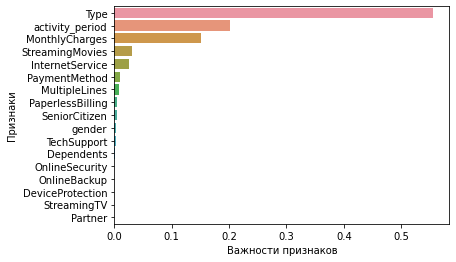

In [94]:
sns.barplot(x= feature_imp, y = feature_imp.index)
plt.xlabel("Важности признаков")
plt.ylabel("Признаки")
plt.show()

Наиболее важными для классификации оказались признаки: тип оплаты, период активности, ежемесячные траты на услуги и каталог фильмов.

#### Random Forest

В качестве гиперпараметров модели будем выбирать глубину дерева, т.е. `max_depth`, и число деревьев, т.е. `n_estimators` 

In [95]:
param_grid = { 
    'n_estimators': [50, 100, 125, 150, 200, 250],
    'max_depth' : range(6, 13, 2)
}

In [96]:
RF_model = GridSearchCV(RandomForestClassifier(random_state=210223, class_weight='balanced'), 
                        param_grid, cv = cv, scoring = 'roc_auc', n_jobs = -1)

In [97]:
RF_model.fit(features_train_cat, target_train)

GridSearchCV(cv=StratifiedShuffleSplit(n_splits=10, random_state=210223, test_size=0.1,
            train_size=None),
             estimator=RandomForestClassifier(class_weight='balanced',
                                              random_state=210223),
             n_jobs=-1,
             param_grid={'max_depth': range(6, 13, 2),
                         'n_estimators': [50, 100, 125, 150, 200, 250]},
             scoring='roc_auc')

In [98]:
print('Параметры лучшей модели', RF_model.best_params_)

Параметры лучшей модели {'max_depth': 8, 'n_estimators': 200}


In [99]:
Results = Results.append({'Model' : 'Random Forest',
                       'ROC-AUC score valid' : RF_model.best_score_,
                       'Fit time': RF_model.cv_results_["mean_fit_time"][RF_model.best_index_]
                        }, ignore_index=True)

In [100]:
# Важность признаков
feature_imp = pd.Series(RF_model.best_estimator_.feature_importances_, index = features_train.columns).sort_values(ascending = False)
feature_imp

activity_period     0.276019
Type                0.229672
MonthlyCharges      0.146962
InternetService     0.096432
PaymentMethod       0.052349
PaperlessBilling    0.029635
OnlineSecurity      0.028606
TechSupport         0.023911
MultipleLines       0.018967
Dependents          0.014941
StreamingMovies     0.014157
OnlineBackup        0.013294
Partner             0.012890
StreamingTV         0.011117
SeniorCitizen       0.010655
gender              0.010272
DeviceProtection    0.010122
dtype: float64

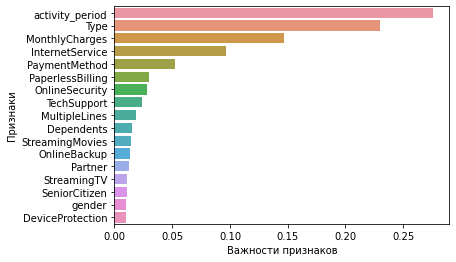

In [101]:
sns.barplot(x= feature_imp, y = feature_imp.index)
plt.xlabel("Важности признаков")
plt.ylabel("Признаки")
plt.show()

Для алгоритма случайного леса наиболее важными для классификации оказались признаки: период активности, тип оплаты, ежемесячные траты на услуги, использование интернета, способ оплаты. 

#### LGBM 

Это метод градиентного бустинга. Для всех бустингов одним из ключевых гиперпараметров моделя является скорость обучения, т.е. `learning_rate`. Поэтому кроме числа деревьев и их глубины будем подбирать ещё и скорость обучения алгоритма.

In [102]:
param_grid = { 
    'n_estimators': [100, 125, 150, 200, 250, 300, 350],
    'max_depth' : range(3, 21, 5),
    'learning_rate' : [0.01, 0.05, 0.1, 0.15, 0.2, 0.25]
}

In [103]:
LGBM_model = GridSearchCV(LGBMClassifier(random_state=210223, class_weight='balanced'), 
                          param_grid, cv = cv, scoring = 'roc_auc', n_jobs = -1)

In [104]:
LGBM_model.fit(features_train_cat, target_train)


GridSearchCV(cv=StratifiedShuffleSplit(n_splits=10, random_state=210223, test_size=0.1,
            train_size=None),
             estimator=LGBMClassifier(class_weight='balanced',
                                      random_state=210223),
             n_jobs=-1,
             param_grid={'learning_rate': [0.01, 0.05, 0.1, 0.15, 0.2, 0.25],
                         'max_depth': range(3, 21, 5),
                         'n_estimators': [100, 125, 150, 200, 250, 300, 350]},
             scoring='roc_auc')

In [105]:
print('Параметры лучшей модели', LGBM_model.best_params_)

Параметры лучшей модели {'learning_rate': 0.25, 'max_depth': 3, 'n_estimators': 350}


In [106]:
Results = Results.append({'Model' : 'LGBM',
                       'ROC-AUC score valid' : LGBM_model.best_score_,
                       'Fit time': LGBM_model.cv_results_["mean_fit_time"][LGBM_model.best_index_]
                        }, ignore_index=True)

In [107]:
# Важность признаков
feature_imp = pd.Series(LGBM_model.best_estimator_.feature_importances_, index = features_train.columns).sort_values(ascending = False)
feature_imp

activity_period     1092
MonthlyCharges       652
PaymentMethod         82
Type                  71
MultipleLines         58
Dependents            47
gender                46
Partner               46
PaperlessBilling      34
InternetService       33
OnlineSecurity        32
TechSupport           30
SeniorCitizen         23
OnlineBackup          22
StreamingTV           22
DeviceProtection      18
StreamingMovies       15
dtype: int64

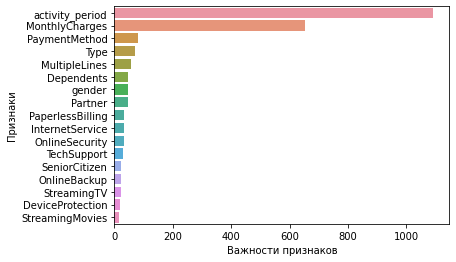

In [108]:
sns.barplot(x= feature_imp, y = feature_imp.index)
plt.xlabel("Важности признаков")
plt.ylabel("Признаки")
plt.show()

Для алгоритма `LightGBM` наиболее важными для классификации оказались признаки: период активности, ежемесячные траты на услуги, тип оплаты, способ оплаты и наличие возможности ведения параллельных линий во время звонка.

#### CatBoost

In [109]:
param_grid = { 
    'depth' : range(4, 11, 2),
    'learning_rate' : [0.1, 0.15, 0.2, 0.25, 0.5]
}

In [110]:
CatBoost_model = GridSearchCV(CatBoostClassifier(random_state=210223, cat_features=categorical, iterations = 1000),
                              param_grid, cv = cv, scoring = 'roc_auc', n_jobs = -1)

In [111]:
CatBoost_model.fit(features_train, target_train)

0:	learn: 0.5841234	total: 58.1ms	remaining: 58s
1:	learn: 0.5228978	total: 65.2ms	remaining: 32.5s
2:	learn: 0.4917923	total: 72.4ms	remaining: 24s
3:	learn: 0.4602717	total: 79.6ms	remaining: 19.8s
4:	learn: 0.4421469	total: 86.4ms	remaining: 17.2s
5:	learn: 0.4282630	total: 96.9ms	remaining: 16.1s
6:	learn: 0.4187686	total: 104ms	remaining: 14.7s
7:	learn: 0.4126910	total: 111ms	remaining: 13.7s
8:	learn: 0.4097712	total: 115ms	remaining: 12.7s
9:	learn: 0.4047534	total: 123ms	remaining: 12.1s
10:	learn: 0.4030107	total: 126ms	remaining: 11.4s
11:	learn: 0.4008351	total: 133ms	remaining: 10.9s
12:	learn: 0.3976926	total: 139ms	remaining: 10.5s
13:	learn: 0.3948954	total: 146ms	remaining: 10.3s
14:	learn: 0.3931019	total: 153ms	remaining: 10.1s
15:	learn: 0.3902263	total: 160ms	remaining: 9.83s
16:	learn: 0.3884677	total: 167ms	remaining: 9.63s
17:	learn: 0.3874544	total: 174ms	remaining: 9.48s
18:	learn: 0.3863244	total: 180ms	remaining: 9.31s
19:	learn: 0.3850499	total: 187ms	remai

GridSearchCV(cv=StratifiedShuffleSplit(n_splits=10, random_state=210223, test_size=0.1,
            train_size=None),
             estimator=<catboost.core.CatBoostClassifier object at 0x7f1cbe3cc7c0>,
             n_jobs=-1,
             param_grid={'depth': range(4, 11, 2),
                         'learning_rate': [0.1, 0.15, 0.2, 0.25, 0.5]},
             scoring='roc_auc')

In [112]:
print('Параметры лучшей модели', CatBoost_model.best_params_)

Параметры лучшей модели {'depth': 4, 'learning_rate': 0.2}


In [113]:
Results = Results.append({'Model' : 'CatBoost',
                       'ROC-AUC score valid' : CatBoost_model.best_score_,
                       'Fit time': CatBoost_model.cv_results_["mean_fit_time"][CatBoost_model.best_index_]
                        }, ignore_index=True)

In [114]:
# Важность признаков
feature_imp = pd.Series(CatBoost_model.best_estimator_.feature_importances_, index = features_train.columns).sort_values(ascending = False)
feature_imp

activity_period     57.683133
MonthlyCharges      15.503601
Type                 7.139784
PaymentMethod        3.902123
MultipleLines        3.321822
InternetService      3.280855
PaperlessBilling     1.319758
OnlineSecurity       1.138194
Dependents           1.055364
SeniorCitizen        0.935564
Partner              0.902208
TechSupport          0.776503
StreamingMovies      0.689943
OnlineBackup         0.617087
gender               0.603862
StreamingTV          0.572180
DeviceProtection     0.558018
dtype: float64

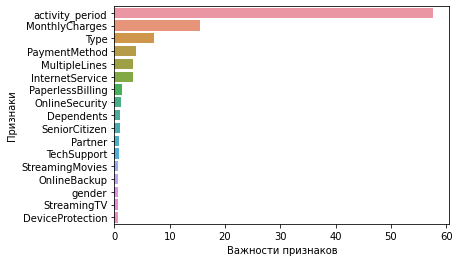

In [115]:
sns.barplot(x= feature_imp, y = feature_imp.index)
plt.xlabel("Важности признаков")
plt.ylabel("Признаки")
plt.show()

Для алгоритма CatBoost наиболее важными для классификации оказались признаки: период активности, ежемесячные траты на услуги, тип оплаты.

Анализ важности признаков позволяет не только построить лучшую модель и уменьшить число признаков для обучения. Мы также можем выдать рекомендации бизнесу, изучив влияние признаков на отток, тем самым можно повысить качество определенных услуг, например, онлайн-платежи или интернет на оптоволокне.


### Сравнение результатов

In [116]:
# Выведем результаты обучения всех моделей, записанные в таблице Results
Results

,Model,ROC-AUC score valid,Fit time
0,KNN,0.813151,0.012430
1,Logistic Regression,0.838721,0.108456
2,Decision Tree,0.840336,0.023337
3,Random Forest,0.857393,1.176095
4,LGBM,0.906639,0.351059
5,CatBoost,0.926121,17.833379


Видим, что модель k-ближайших соседей имеет наименьшее время обучения, но метрика ROC-AUC для этой модели на валидационной выборке оказалось минимальной среди метрик всех рассмотренных моделей. Для всех моделей метрика ROC-AUC > 0.82. Наилучший результат качества обучения имеет алгоритм CatBoost, но обучение длилось существенно дольше, чем для LightGBM Classifier. На основании полученных результатов, делаем вывод, что наиболее эффективной моделью среди рассмотренных моделей бинарной классификации является модель CatBoost (с точки зрения метрики качества).

### Оценка адекватности модели

Оценка адекватности модели предполагает сравнение ее с простой "угадалкой" (угадайка даст на точность 0,5). Но в данном случае стоит учесть момент с дисбаланом классов в таргете. 

Например, обучили мы какую-то модель, которая на test показывает 90% accuraсy. Шикарная модель, скажем мы. А если в датасете у нас в метках таргета единичек 99,9% (допустим тренируем на данных где 1 это "кирпич упал на голову человеку, когда он вышел из дома"), а нулей 0,1% ("не упал")?! Все также утверждаем что наша модель шикарная?!

Таким образом, смысл проверки на адекватность  - сравнение нашей обученной модели с примитивным прогнозом самого частого таргета.

При проверке на адекватность модели, рекомендую ознакомиться с `Dummy Models`, это удобная обертка для константных моделей.

In [117]:
dummy_model = DummyClassifier(strategy="most_frequent", random_state = 210223)
ROC_AUC = cross_val_score(dummy_model, features_train, target_train, cv = cv, scoring = 'roc_auc', n_jobs = -1) 

print('ROC-AUC на валидационной выборке константной модели: ', ROC_AUC.mean())

ROC-AUC на валидационной выборке константной модели:  0.5


Учитывая существенное преобладание объектов класса 0 в исходных данных, обощающую способность всех построенных моделей можно считать хорошей, все модели можно считать адекватными.

### Проверка на тестовом наборе

Оценим результаты работы "лучшей" модели на тестовом наборе данных. 

Для прогнозирования результатов на новом наборе данных используют метод `predict()`.

In [118]:
model_pred = CatBoost_model.best_estimator_.predict(features_test)


Вычислим метрики качества на тестовой выборке.

In [119]:
print('Accuracy на тестовом наборе', accuracy_score(target_test, model_pred))
print('F-мера на тестовом наборе',f1_score(target_test, model_pred))
print('ROC_AUC на тестовом наборе', roc_auc_score(target_test, CatBoost_model.best_estimator_.predict_proba(features_test)[:, 1]))

Accuracy на тестовом наборе 0.8898353208404316
F-мера на тестовом наборе 0.7749419953596287
ROC_AUC на тестовом наборе 0.9421121698234977


Построим матрицу ошибок в виде тепловой карты.

              precision    recall  f1-score   support

           0       0.90      0.95      0.93      1294
           1       0.85      0.72      0.77       467

    accuracy                           0.89      1761
   macro avg       0.87      0.83      0.85      1761
weighted avg       0.89      0.89      0.89      1761



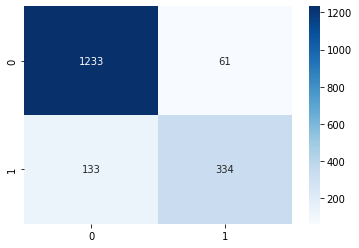

In [120]:
conf_matrix = confusion_matrix(target_test, model_pred)

sns.heatmap(conf_matrix, annot = True, cmap = 'Blues', fmt = 'd')
print(classification_report(target_test, model_pred))

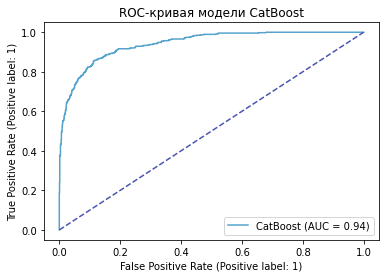

In [121]:
# ROC-кривая построенной модели
plot_roc_curve(CatBoost_model.best_estimator_, features_test, target_test, name='CatBoost')
plt.plot([0, 1], [0, 1], linestyle='--')
plt.title('ROC-кривая модели CatBoost')
plt.show()

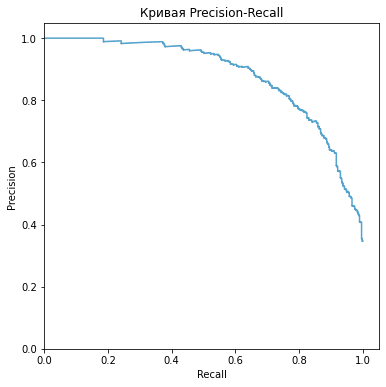

In [122]:
# Кривая Precision-Recall
probabilities_test = CatBoost_model.best_estimator_.predict_proba(features_test)
precision, recall, thresholds = precision_recall_curve(target_test, probabilities_test[:, 1])

plt.figure(figsize=(6, 6))
plt.step(recall, precision, where='post')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.05])
plt.title('Кривая Precision-Recall')
plt.show() 

### Выводы

По результататм тестирования "лучшей" модели делаем вывод о достаточно хорошей обощающей способности модели. На тестовом наборе метрика `accuracy` составляет 0.89, `F-мера` равна 0.77, значение `roc-auc` составило 0.94, что говорит о хорошем качестве построенного классификатора. Однако на тестовом наборе данных значение Recall для объектов класса 1 составляет 0,72, т.е. 72% ушедших клиентов идентифицированы моделью верно. Это связано в первую очередь с тем, что общее количество таких пользователей составляет менее 1/3 от общего числа клиентов.
